# RNA-Seq Pipeline: Step 5 - DGE Analysis (DESeq2)

This is the final step: **Differential Gene Expression (DGE)** analysis.

**Goal:**
To take the **counts matrix** (from step 4) and the **sample sheet** (metadata) and perform statistical analysis to find out *which genes* are significantly **up-regulated** (more expressed) or **down-regulated** (less expressed) in the "Treated" group compared to the "Control" group.

**Workflow:**
1.  **Setup:** Load the `R` libraries (DESeq2, tidyverse).
2.  **Load Data:** Read the `gene_counts_matrix.txt` and `sample_sheet.csv` files.
3.  **Clean Data:** Prepare the tables for analysis (e.g., make sure sample names match).
4.  **Run DESeq2:** Run the main DGE statistical model.
5.  **Get Results:** Extract the final results table (Log2FoldChange, p-value).
6.  **Visualize:** Create plots (like a Volcano plot and PCA plot) to visualize the results.

**Tool:** `DESeq2` (an `R` package)

In [1]:
# --- 1. Load Libraries ---
# 'suppressPackageStartupMessages' just hides the messy startup text
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(EnhancedVolcano))

print("Libraries loaded successfully.")

[1] "Libraries loaded successfully."


In [2]:
# --- 2. Load Data ---
counts_file <- "04_Counts/gene_counts_matrix.txt"
metadata_file <- "docs/sample_sheet.csv"

sample_sheet <- read_csv(metadata_file) %>% 
                  column_to_rownames("SampleID")

counts_data <- read.delim(counts_file, skip = 1, row.names = 1)

# --- 3. Clean Data (THIS IS THE FIX) ---

# (Verification) Let's see the ugly names R loaded:
print("--- Original (Ugly) Column Names from featureCounts ---")
print(colnames(counts_data))

# FIX: Clean the column names.
# We remove the prefix (like "X03_Aligned_BAMs.")
# and the suffix (like ".sorted.bam")

# Create a new, clean list of names
clean_names <- colnames(counts_data)
# Remove the path prefix (handles "X03_..." or "03_...")
clean_names <- gsub("^X?03_Aligned_BAMs\\.", "", clean_names) 
# Remove the file suffix
clean_names <- gsub("\\.sorted\\.bam$", "", clean_names)       

# Assign these new, clean names back to the data frame
colnames(counts_data) <- clean_names

# (Verification) Let's see the new, clean names
print("--- New (Cleaned) Column Names ---")
print(colnames(counts_data))


# Now, select ONLY the 6 columns that match our sample sheet
# (This ignores "Chr", "Start", "End", etc.)
counts_data_cleaned <- counts_data %>% 
                         select(rownames(sample_sheet))

# (Verification) Check if the orders match. This must be TRUE.
print("--- Do columns and rows match? ---")
print(all(colnames(counts_data_cleaned) == rownames(sample_sheet)))


# --- 4. Print Data (to verify) ---
print("--- Sample Sheet (Metadata) ---")
print(sample_sheet)
print("--- Counts Data (Cleaned) ---")
print(head(counts_data_cleaned))

Rows: 6 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): SampleID, Condition

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "--- Original (Ugly) Column Names from featureCounts ---"
 [1] "Chr"                                    
 [2] "Start"                                  
 [3] "End"                                    
 [4] "Strand"                                 
 [5] "Length"                                 
 [6] "X03_Aligned_BAMs.SRR34134104.sorted.bam"
 [7] "X03_Aligned_BAMs.SRR34134105.sorted.bam"
 [8] "X03_Aligned_BAMs.SRR34134106.sorted.bam"
 [9] "X03_Aligned_BAMs.SRR34134107.sorted.bam"
[10] "X03_Aligned_BAMs.SRR34134108.sorted.bam"
[11] "X03_Aligned_BAMs.SRR34134109.sorted.bam"
[1] "--- New (Cleaned) Column Names ---"
 [1] "Chr"         "Start"       "End"         "Strand"      "Length"     
 [6] "SRR34134104" "SRR34134105" "SRR34134106" "SRR34134107" "SRR34134108"
[11] "SRR34134109"
[1] "--- Do columns and rows match? ---"
[1] TRUE
[1] "--- Sample Sheet (Metadata) ---"
            Condition
SRR34134104   Control
SRR34134105   Control
SRR34134106   Control
SRR34134107   Treated
SRR34134108  

### 4. Run the DESeq2 Analysis

Now that our `counts_data_cleaned` and `sample_sheet` are loaded and aligned, we can run the analysis.

**Workflow:**
1.  **Create DDS Object:** Combine the counts and metadata into a single object called a `DESeqDataSet` (we'll call it `dds`).
2.  **Filter (Optional):** Remove genes with very low counts (e.g., less than 10 reads total) to improve statistical power.
3.  **Run `DESeq()`:** This is the main function. It normalizes the data and fits the statistical model to find differences.

In [3]:
# --- 5. Run DESeq2 ---

# 1. Create the DESeqDataSet (dds) object
# We tell it our "design" (what we want to test) is the "Condition" column
dds <- DESeqDataSetFromMatrix(countData = counts_data_cleaned,
                              colData = sample_sheet,
                              design = ~ Condition)

# 2. (Optional but recommended) Pre-filter low-count genes
# We keep only genes that have at least 10 reads total across all samples
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# 3. Run the main analysis
# This step does normalization, dispersion estimation, and statistical testing
print("--- Running DESeq2 analysis... ---")
dds <- DESeq(dds)
print("--- DESeq2 analysis complete. ---")

# 4. Get the final results table
# We specify the comparison: "Treated" vs "Control"
res <- results(dds, contrast=c("Condition", "Treated", "Control"))

# 5. Print a summary of the results
print("--- Summary of results ---")
print(summary(res))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] "--- Running DESeq2 analysis... ---"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "--- DESeq2 analysis complete. ---"
[1] "--- Summary of results ---"

out of 5294 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1833, 35%
LFC < 0 (down)     : 1858, 35%
outliers [1]       : 1, 0.019%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


### 5. Visualize the Results

The statistical analysis is complete. The results are stored in the `res` object.

Now we will do two things:
1.  **Save Results:** Save the full results table to a `.csv` file for our records.
2.  **PCA Plot:** Create a "Principal Component Analysis" plot. This plot checks if our samples cluster together correctly (i.e., all "Control" samples look similar, and all "Treated" samples look similar).
3.  **Volcano Plot:** Create a "Volcano Plot". This is the most famous plot in DGE. It shows all genes at once:
    * **X-axis:** Log2 Fold Change (how much it changed; right = up, left = down).
    * **Y-axis:** P-value (how significant the change is; higher = more significant).

In [4]:
# --- 6. Save the Results to a File ---

# Create the output directory
output_dir <- "05_DGE_Results"
dir.create(output_dir, showWarnings = FALSE)

# Convert the results to a data.frame and add gene names as a column
res_df <- as.data.frame(res) %>%
          rownames_to_column("GeneID")

# Define the output file path
output_file <- file.path(output_dir, "dge_results_Treated_vs_Control.csv")

# Save the file
write_csv(res_df, output_file)

print(paste("Results saved to:", output_file))
print("--- First 6 rows of the results table: ---")
print(head(res_df))

[1] "Results saved to: 05_DGE_Results/dge_results_Treated_vs_Control.csv"
[1] "--- First 6 rows of the results table: ---"
           GeneID   baseMean log2FoldChange      lfcSE       stat       pvalue
1 gene-KPHS_00010  2616.1869    -0.17285454 0.10434211 -1.6566135 9.759765e-02
2 gene-KPHS_00020  1492.8878    -0.64087520 0.11438998 -5.6025468 2.112250e-08
3 gene-KPHS_00030 20229.7325     0.78399042 0.38587778  2.0317065 4.218337e-02
4 gene-KPHS_00040   686.1182     0.11467337 0.13278560  0.8635980 3.878088e-01
5 gene-KPHS_00050  4395.0650    -0.10807734 0.09474195 -1.1407549 2.539719e-01
6 gene-KPHS_00060  1740.2580     0.03660717 0.11650428  0.3142131 7.533592e-01
          padj
1 1.357289e-01
2 5.403643e-08
3 6.273577e-02
4 4.655641e-01
5 3.202176e-01
6 8.040997e-01


using ntop=500 top features by variance

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the DESeq2 package.
  Please report the issue to the authors.”
Saving 6.67 x 6.67 in image


[1] "--- PCA Plot (checks sample similarity) ---"
[1] "Saved plot to 05_DGE_Results/PCA_plot_samples.png"


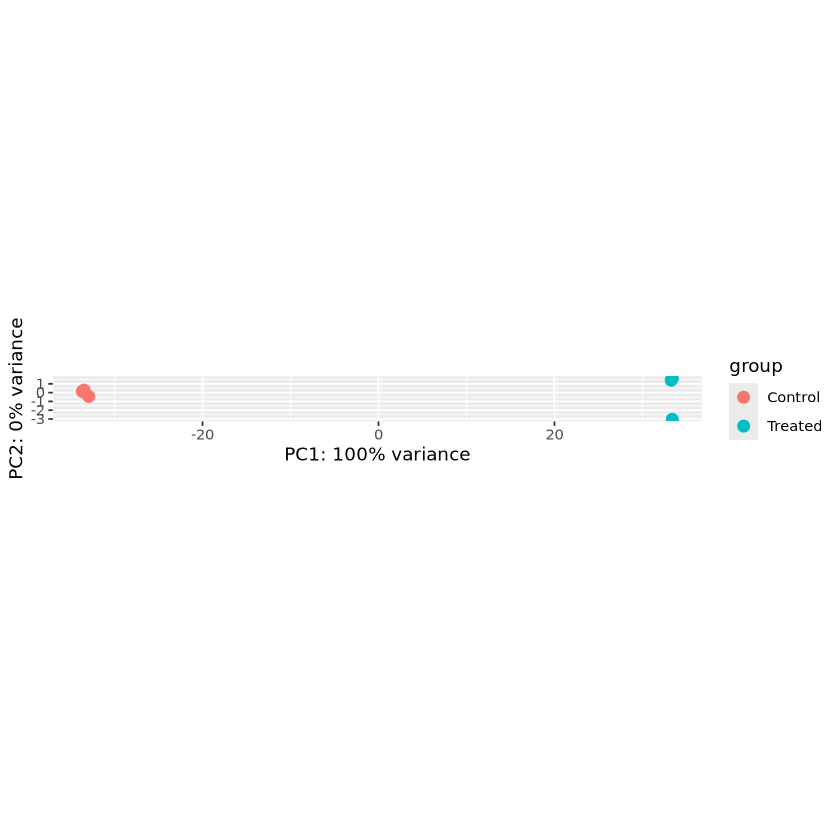

In [5]:
# --- 7. Visualization 1: PCA Plot (Sample Quality Control) ---

# Transform the counts data (VST)
vsd <- vst(dds, blind=FALSE)

# Generate the PCA plot and save it to a variable 'p'
p_pca <- plotPCA(vsd, intgroup=c("Condition"))

# --- THIS IS THE NEW LINE ---
# Save the plot 'p' to a file in our results directory
ggsave(file.path(output_dir, "PCA_plot_samples.png"), plot = p_pca)

print("--- PCA Plot (checks sample similarity) ---")
print("Saved plot to 05_DGE_Results/PCA_plot_samples.png")
p_pca # This line prints the plot to the notebook

[1] "--- Volcano Plot (shows up/down regulated genes) ---"


Warning message:
“One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value...”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”


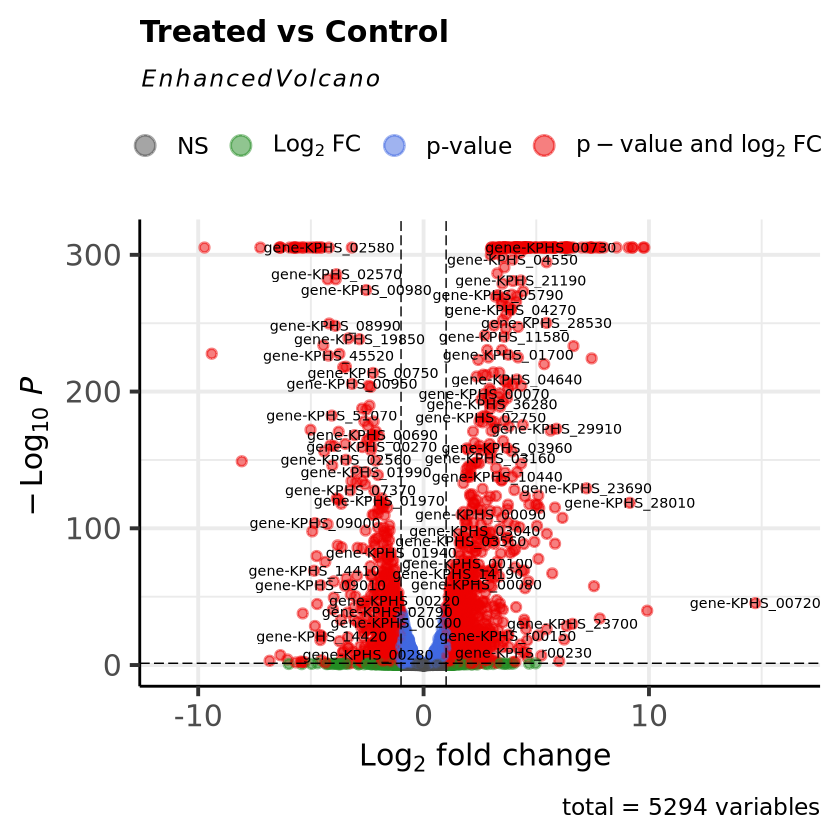

In [6]:
# --- 8. Visualization 2: Volcano Plot (Gene Results) ---

# We use the 'res' object we created earlier

print("--- Volcano Plot (shows up/down regulated genes) ---")

# This uses the EnhancedVolcano library we loaded
EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'padj', # Use the *adjusted* p-value
    title = 'Treated vs Control',
    pCutoff = 0.05,    # Adjusted p-value cutoff (خط الأهمية)
    FCcutoff = 1.0,    # Log2FoldChange cutoff (1.0 = 2-fold change)
    pointSize = 2.0,
    labSize = 3.0)

### 6. Visualization 3: Heatmap of Top Genes

Finally, let's visualize the expression patterns of the most significant genes.

A heatmap allows us to see how the expression of individual genes (rows) changes across all our samples (columns). We will plot the **Top 50** most significant genes (lowest adjusted p-value).

-   We expect to see two main blocks of genes (one up-regulated, one down-regulated).
-   We also expect the samples (columns) to cluster perfectly into "Control" and "Treated" groups, confirming our PCA plot.

[1] "--- Heatmap of Top 50 Significant Genes ---"


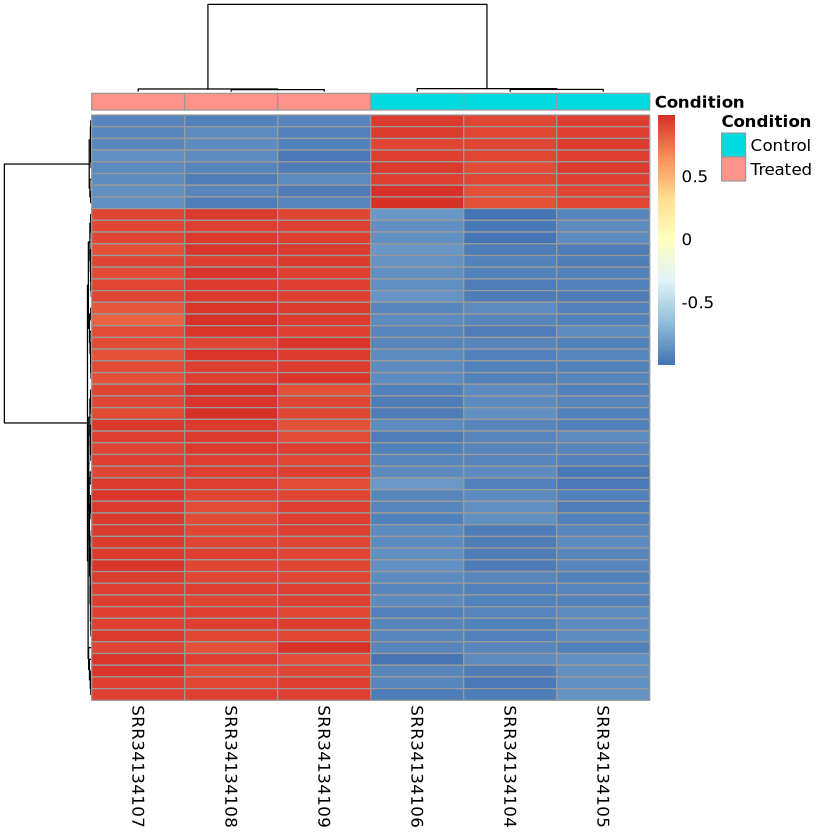

In [7]:
# --- 9. Visualization 3: Heatmap of Top Genes ---

# Load the heatmap library
library(pheatmap)

# 1. Get the top 50 most significant genes (by adjusted p-value)
# We take 'res' (the results object), order by padj, and get the names
top_genes <- head(order(res$padj), 50)

# 2. Get the normalized counts matrix (from the 'vsd' object in Cell 8)
norm_counts_matrix <- assay(vsd)

# 3. Filter the matrix to only these top 50 genes
top_genes_matrix <- norm_counts_matrix[top_genes, ]

# 4. Scale the data by gene (row) to get Z-scores
# This shows relative expression (high vs low), which is better for a heatmap
scaled_matrix <- t(scale(t(top_genes_matrix)))

# 5. Create the heatmap!
# We use 'sample_sheet' (from Cell 3) as the annotation for the columns
print("--- Heatmap of Top 50 Significant Genes ---")
pheatmap(scaled_matrix, 
         annotation_col = sample_sheet,
         show_rownames = FALSE, # Hide gene names (they are too many)
         cluster_rows = TRUE,   # Group similar genes together
         cluster_cols = TRUE)  # Group similar samples together